# **Skin disease classification using a SWIN Transformer**

# 1. Importing (and/or installing) the necessary libraries
We also define a function to print the elapsed time for resource management purposes.

In [1]:
import time

start_time = time.time()

def print_elapsed_time():
    elapsed_time = time.time() - start_time
    hours, remainder = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f"Elapsed time: {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds", flush=True)

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score
import os
from torchvision.datasets import VisionDataset
from torchvision.datasets.folder import IMG_EXTENSIONS, default_loader
from torchvision.datasets.utils import list_files
import torch.optim.lr_scheduler as lr_scheduler
from transformers import AutoImageProcessor, AutoModelForImageClassification
import random
from holisticai.bias.metrics import disparate_impact, precision_matrix
from fairlearn.metrics import equalized_odds_ratio
from IPython.display import Image, display
import PIL
from tqdm.notebook import tqdm

# 2. Building the dataset class

In [3]:
# settings: defining the folder path, the usual skin diseases list and the device (hopefully a GPU)
folder_path = 'leonardo/colab'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device, '\n', flush=True)

diseases = ['esantema-iatrogeno-farmaco-indotta', 'esantema-maculo-papuloso', 'esantema-morbilliforme', 'esantema-polimorfo-like',
                    'esantema-virale', 'orticaria', 'pediculosi', 'scabbia', 'varicella']

Device: cpu 



In [4]:
class CustomImageFolderColor(VisionDataset):
    def __init__(self, root, transform=transforms.ToTensor(), target_transform=None):
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(diseases)}
        self.imgs = self._load_imgs()

    def _load_imgs(self):
        # here, I first create a dictionary which associates each image path to its skin label. After that, I incorporate this label in my data.

        imgs = []
        for disease in tqdm(diseases):
          df = pd.read_csv(f"{self.root}/skin_color_datasets/{disease}_ITA.csv")
          skin_labels = df["skin_label"]
          img_paths = df["img_path"]

          imgs.extend([(img.replace("leonardo/", ""), skin_label, self.class_to_idx[disease]) for img, skin_label in zip(img_paths, skin_labels)])
        
        return imgs

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path, skin_label, target = self.imgs[idx]
        print(img_path)
        img = default_loader(img_path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, skin_label, target

In [5]:
###################### SET THE SEED FOR REPRODUCIBILITY ########################
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

############################### INSTANTIATING THE DATASET AND SPLITTING ###########################################
dataset = CustomImageFolderColor(folder_path)

# Split the dataset into train and test sets
train_size = int(0.6 * len(dataset))  # 60% train, 20% validation, 20% test
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

  0%|          | 0/9 [00:00<?, ?it/s]

# 3. Building the model

The chosen architecture is a **Swin Transformer**, firstly introduced by Liu et al (https://arxiv.org/abs/2103.14030). An image of the architecture is shown below.
The Swin Transformer is a type of Vision Transformer. It builds hierarchical feature maps by merging image patches in deeper layers and has linear computation complexity to input image size due to computation of self-attention only within each local window. It can thus serve as a general-purpose backbone for both image classification and dense recognition tasks. In contrast, previous vision Transformers produce feature maps of a single low resolution and have quadratic computation complexity to input image size due to computation of self-attention globally.

In [15]:
display(Image(url='https://ars.els-cdn.com/content/image/1-s2.0-S0952197623008539-gr4.jpg', width=800, height=450))

In [17]:
processor = AutoImageProcessor.from_pretrained('SWIN')
model = AutoModelForImageClassification.from_pretrained('SWIN', num_labels=9, ignore_mismatched_sizes=True)

print(f'Detected {torch.cuda.device_count()} devices', '\n', flush=True)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model.to(device)

Detected 0 devices 



SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
  

We decide to train the last two stages of the Transformer, for a total of about 26 million parameters.

In [18]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze specific layers
for name, param in model.named_parameters():
    if "classifier" in name or "swin.layernorm" in name or "swin.encoder.layers.3" in name or "swin.encoder.layers.2" in name:
        param.requires_grad = True

# Print trainable parameters to verify
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable Layer: {name} | Size: {param.size()}", '\n', flush=True)

Trainable Layer: swin.encoder.layers.2.blocks.0.layernorm_before.weight | Size: torch.Size([384]) 

Trainable Layer: swin.encoder.layers.2.blocks.0.layernorm_before.bias | Size: torch.Size([384]) 

Trainable Layer: swin.encoder.layers.2.blocks.0.attention.self.relative_position_bias_table | Size: torch.Size([169, 12]) 

Trainable Layer: swin.encoder.layers.2.blocks.0.attention.self.query.weight | Size: torch.Size([384, 384]) 

Trainable Layer: swin.encoder.layers.2.blocks.0.attention.self.query.bias | Size: torch.Size([384]) 

Trainable Layer: swin.encoder.layers.2.blocks.0.attention.self.key.weight | Size: torch.Size([384, 384]) 

Trainable Layer: swin.encoder.layers.2.blocks.0.attention.self.key.bias | Size: torch.Size([384]) 

Trainable Layer: swin.encoder.layers.2.blocks.0.attention.self.value.weight | Size: torch.Size([384, 384]) 

Trainable Layer: swin.encoder.layers.2.blocks.0.attention.self.value.bias | Size: torch.Size([384]) 

Trainable Layer: swin.encoder.layers.2.blocks.0.a

In [19]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}", '\n', flush=True)

Trainable parameters: 26033985 



# 4. Utilities

## Dataloaders

First we define the batch size, the epoch and the learning rate hyperparameters:

In [125]:
BATCH_SIZE = 512
EPOCHS = 16
LEARNING_RATE = 1e-2
print(f"LEARNING_RATE: {LEARNING_RATE}, BATCH_SIZE: {BATCH_SIZE}, N_EPOCHS: {EPOCHS}", '\n', flush=True)

LEARNING_RATE: 0.01, BATCH_SIZE: 512, N_EPOCHS: 16 



In [27]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

## Loss, Optimizer, Scheduler and EarlyStopper

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, momentum=0.9)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[9, 17], gamma=0.001)           

# 4. Training the model

In [11]:
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in range(EPOCHS):  # You can adjust the number of epochs

    train_loss = 0.0
    val_loss = 0.0
    running_loss = 0.0

    all_train_preds = []
    all_train_labels = []

    model.train()

    correct = 0

    for i, data in enumerate(train_loader, 0):
        # get the inputs and process them in order to fit to the model requirements
        inputs, _, labels = data
        inputs = processor(inputs, return_tensors="pt", do_rescale=False)['pixel_values']
        labels = labels.long()
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        # store loss for plotting later
        train_loss += loss.item()
        running_loss += loss.item()

        # collect predictions and true labels for F1 score calculation
        _, preds = torch.max(outputs.logits, 1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

        correct += (preds == labels).sum().item()

        # print statistics
        if i % 1000 == 0:    # print every 1000 mini-batches
            if i == 0:
                print(f'[Epoch {epoch + 1}, Batch {i + 1:5d} / {len(train_loader)}] Training Loss: {running_loss}', flush=True)
            else:
                print(f'[Epoch {epoch + 1}, Batch {i + 1:5d} / {len(train_loader)}] Training Loss: {running_loss / 1000:.3f}', flush=True)
                running_loss = 0.0

    # print accuracy
    accuracy = correct / len(train_dataset)
    print(f'Accuracy on train set: {accuracy}', flush=True)

    # Calculate training F1 score for the epoch
    train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
    train_f1_scores.append(train_f1)
    print(f'F1 score on train set: {train_f1}', flush=True)

    train_losses.append(train_loss / len(train_loader))

    # Validation loop
    model.eval()

    all_val_preds = []
    all_val_labels = []
    val_correct = 0

    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, _, labels = data
            inputs = processor(inputs, return_tensors="pt", do_rescale=False)['pixel_values']
            labels = labels.long()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(pixel_values=inputs)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            # collect predictions and true labels for F1 score and accuracy calculation
            _, preds = torch.max(outputs.logits, 1)
            val_correct += (preds == labels).sum().item()
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())
    
    # print accuracy 
    val_accuracy = val_correct / len(val_dataset)
    print(f"Accuracy on validation set: {val_accuracy}", flush=True)

    # Calculate validation F1 score for the epoch
    val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')
    val_f1_scores.append(val_f1)
    print(f'F1 score on validation set: {val_f1}', flush=True)

    val_losses.append(val_loss / len(val_loader))

    print(f'[Epoch {epoch + 1}, Validation Loss: {val_loss / len(val_loader):.3f}]', flush=True)

        # save the model if validation loss is lower than previous epoch
    if val_f1_scores[epoch] > val_f1_scores[epoch-1]:
        torch.save(model.state_dict(), f'colab/SWIN/weights/epcs_{EPOCHS}__lr_{LEARNING_RATE}__bs_{BATCH_SIZE}_def2.pth')

        checkpoint = {
        'epoch': epoch,
        'optimizer_state_dict': optimizer.state_dict(),
        #'scheduler_state_dict' : scheduler.state_dict(),
        'loss': loss.item()}

        torch.save(checkpoint, f'colab/SWIN/{EPOCHS}_{LEARNING_RATE}_{BATCH_SIZE}_TR_def2/best_checkpoint.pth')

        # early stopping
    """
    if early_stopper.early_stop(val_losses[epoch]):
        torch.save(model.state_dict(), f'colab/SWIN/weights/epcs_{EPOCHS}__lr_{LEARNING_RATE}__bs_{BATCH_SIZE}_LASTEPOCH_def2.pth')
        print('EARLY STOPPING THE TRAINING', '\n', flush=True)
        break
    """

        # cosine annealing step
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    print('UPDATING LEARNING RATE TO: ', current_lr, flush=True)

    print_elapsed_time()

    # save loss and F1 score plots to file
    # Plotting the training and validation loss
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot F1 Score
    plt.subplot(1, 2, 2)
    plt.plot(train_f1_scores, label='Training F1 Score')
    plt.plot(val_f1_scores, label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'colab/SWIN/plots/epcs_{EPOCHS}__lr_{LEARNING_RATE}__bs_{BATCH_SIZE}_def2.png')

    checkpoint = {
    'epoch': epoch,
    'optimizer_state_dict': optimizer.state_dict(),
    #'scheduler_state_dict' : scheduler.state_dict(),
    'loss': loss.item()}

    torch.save(checkpoint, f'colab/SWIN/{EPOCHS}_{LEARNING_RATE}_{BATCH_SIZE}_TR_def2/checkpoint.pth')

print('Finished Training', '\n', flush=True)

torch.save(model.state_dict(), f'colab/SWIN/weights/epcs_{EPOCHS}__lr_{LEARNING_RATE}__bs_{BATCH_SIZE}_LASTEPOCH_def2.pth')

[Epoch 1, Batch     1 / 387] Training Loss: 2.2712771892547607
Accuracy on train set: 0.6737851119335072
F1 score on train set: 0.5576003047411322
Accuracy on validation set: 0.719165200509616
F1 score on validation set: 0.6744923962320357
[Epoch 1, Validation Loss: 0.790]
UPDATING LEARNING RATE TO:  0.01
Elapsed time: 0 hours, 58 minutes, 36 seconds
[Epoch 2, Batch     1 / 387] Training Loss: 0.682073712348938
Accuracy on train set: 0.8358510788893607
F1 score on train set: 0.8030003023878756
Accuracy on validation set: 0.8243493296123279
F1 score on validation set: 0.7976468150244523
[Epoch 2, Validation Loss: 0.509]
UPDATING LEARNING RATE TO:  0.01
Elapsed time: 1 hours, 57 minutes, 20 seconds
[Epoch 3, Batch     1 / 387] Training Loss: 0.341732919216156
Accuracy on train set: 0.896064632247366
F1 score on train set: 0.8791760608344547
Accuracy on validation set: 0.8683643754170964
F1 score on validation set: 0.8429461742969863
[Epoch 3, Validation Loss: 0.387]
UPDATING LEARNING RAT

## Results

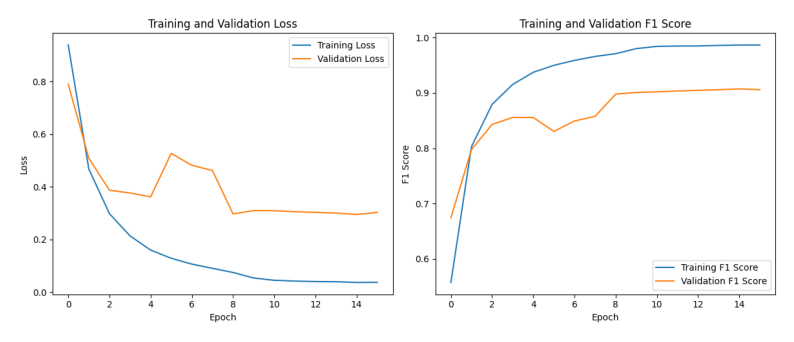

In [12]:
image_path = "leonardo/colab/SWIN/plots/epcs_16__lr_0.01__bs_512_def2.png"  

image = PIL.Image.open(image_path)
plt.figure(figsize=(10, 10))  
plt.imshow(image)
plt.axis('off')  
plt.show()

# 5. Evaluating the model

This step involves the evaluation of the network's performance according to 'traditional' metrics (accuracy, F1 scores) and fairness metrics, which are specifically designed to assess the presence of bias.

First, we retrieve the predictions of the model on the test set:

In [ ]:
model.eval()

# prepare to store the predictions for the computation of the FAIRNESS METRICS
pred_fairness = []
labels_fairness = []
skin_labels_fairness = []

# again no gradients needed
with torch.no_grad():
    i = 0
    for data in test_loader:
        print(f'Evaluating batch number {i}/{len(test_loader)}', flush=True)
        i += 1
        images, skin_labels, labels = data
        images = processor(images, return_tensors="pt", do_rescale=False)['pixel_values']
        labels = labels.long()
        images, labels = images.to(device), labels.to(device)
        outputs = model(pixel_values=images)
        _, predictions = torch.max(outputs.logits, 1)
        # collect the correct predictions for each class and skin color for the computation of ACCURACY
        for label, skin_label, prediction in zip(labels.tolist(), skin_labels, predictions.tolist()):
            pred_fairness.append(prediction)
            labels_fairness.append(label)
            skin_labels_fairness.append(skin_label)

In [101]:
import pandas as pd

df = pd.read_csv("final_predictions1e-4_swin_def.csv")
labels_fairness = df['labels_fairness']
pred_fairness = df ['pred_fairness']
skin_labels_fairness = df['skin_labels_fairness']

## Overall accuracy and F1 score

We compute the overall accuracy and F1 score:

In [127]:
print(f'Overall accuracy: {accuracy_score(labels_fairness, pred_fairness)*100:.1f}%', flush=True)
print(f"Overall F1 score: {f1_score(labels_fairness, pred_fairness, average='macro'):.2f}", flush=True)

Overall accuracy: 91.3%
Overall F1 score: 0.90


We evaluate the accuracy of the network for every skin tone.

In [21]:
from collections import defaultdict

def compute_accuracy_by_skin_label(pred_fairness, labels_fairness, skin_labels_fairness):
    """
    Compute accuracy for each unique skin label.
    
    Parameters:
    - pred_fairness: List of model predictions.
    - labels_fairness: List of true labels.
    - skin_labels_fairness: List of skin labels corresponding to each prediction/label.
    
    Returns:
    - accuracy_by_skin_label: Dictionary with skin labels as keys and accuracy as values.
    """
    
    # Dictionary to hold counts of correct predictions and total samples per skin label
    correct_predictions = defaultdict(int)
    total_samples = defaultdict(int)
    
    # Iterate through predictions, true labels, and skin labels
    for pred, true_label, skin_label in zip(pred_fairness, labels_fairness, skin_labels_fairness):
        total_samples[skin_label] += 1  # Count the sample for this skin label
        if pred == true_label:
            correct_predictions[skin_label] += 1  # Count correct prediction if it matches the true label
    
    # Calculate accuracy per skin label
    accuracy_by_skin_label = {
        skin_label: correct_predictions[skin_label] / total_samples[skin_label]
        for skin_label in total_samples
    }
    
    return accuracy_by_skin_label

accuracy_per_skin_label = compute_accuracy_by_skin_label(pred_fairness, labels_fairness, skin_labels_fairness)

for item in accuracy_per_skin_label:
    print(f'Accuracy for skin tone {item}: {accuracy_per_skin_label[item]*100:.1f}%')

Accuracy for skin tone light: 90.3%
Accuracy for skin tone very light: 91.5%
Accuracy for skin tone tan: 91.9%
Accuracy for skin tone intermediate: 91.7%
Accuracy for skin tone brown: 91.2%
Accuracy for skin tone dark: 90.8%


We also evaluate the F1 score of the network for every skin tone.

In [128]:
from sklearn.metrics import f1_score
from collections import defaultdict

def compute_f1_by_skin_label(pred_fairness, labels_fairness, skin_labels_fairness):
    """
    Compute F1 score for each unique skin label using sklearn's f1_score function.
    
    Parameters:
    - pred_fairness: List of model predictions.
    - labels_fairness: List of true labels.
    - skin_labels_fairness: List of skin labels corresponding to each prediction/label.
    
    Returns:
    - f1_by_skin_label: Dictionary with skin labels as keys and F1 scores as values.
    """
    
    # Dictionary to hold F1 scores for each skin label
    f1_by_skin_label = {}

    # Get unique skin labels
    unique_skin_labels = set(skin_labels_fairness)
    
    # Calculate F1 score for each skin label
    for skin_label in unique_skin_labels:
        # Filter predictions and true labels by current skin label
        indices = [i for i, label in enumerate(skin_labels_fairness) if label == skin_label]
        filtered_preds = [pred_fairness[i] for i in indices]
        filtered_labels = [labels_fairness[i] for i in indices]
        
        # Calculate F1 score for the current skin label
        f1 = f1_score(filtered_labels, filtered_preds, average='weighted')
        f1_by_skin_label[skin_label] = f1
    
    return f1_by_skin_label

f1_per_skin_label = compute_f1_by_skin_label(pred_fairness, labels_fairness, skin_labels_fairness)

for item in f1_per_skin_label:
    print(f'F1 score for skin tone {item}: {f1_per_skin_label[item]:.2f}')

F1 score for skin tone brown: 0.91
F1 score for skin tone tan: 0.92
F1 score for skin tone light: 0.90
F1 score for skin tone very light: 0.92
F1 score for skin tone dark: 0.91
F1 score for skin tone intermediate: 0.92


Additionally, we show the overall confusion matrices for each skin tone.

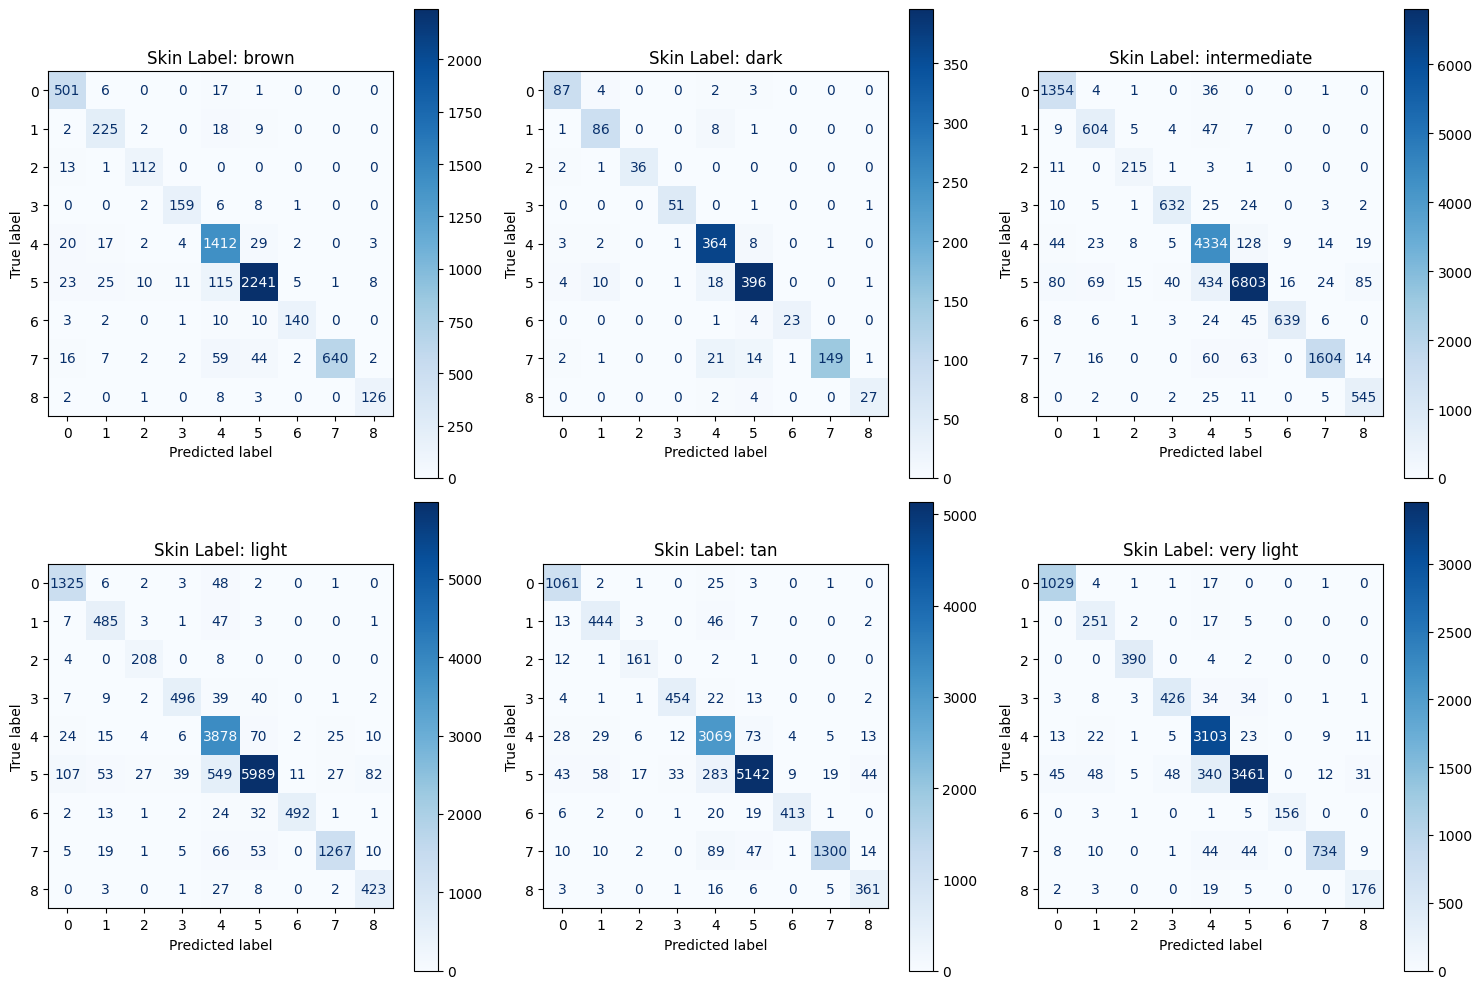

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert lists to numpy arrays for easier processing
labels_fairness = np.array(labels_fairness)
pred_fairness = np.array(pred_fairness)
skin_labels_fairness = np.array(skin_labels_fairness)

# Get unique skin labels
unique_skin_labels = np.unique(skin_labels_fairness)

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()  # Flatten the axes array for easier iteration

# Plot confusion matrices for each skin label
for i, skin_label in enumerate(unique_skin_labels):
    # Filter labels and predictions for the current skin label
    indices = np.where(skin_labels_fairness == skin_label)
    filtered_labels = labels_fairness[indices]
    filtered_predictions = pred_fairness[indices]

    # Compute confusion matrix
    cm = confusion_matrix(filtered_labels, filtered_predictions)
    
    # Create a ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    # Plot the confusion matrix on the corresponding subplot
    disp.plot(ax=axes[i], cmap=plt.cm.Blues)
    axes[i].set_title(f"Skin Label: {skin_label}")

# Adjust layout
plt.tight_layout()
plt.show()

From now on, we will consider the following aggregation for the skin tones: 
- "brown", "dark" ---> Minority
- all the other skin tones ---> Majority

We compute the overall Accuracy and F1 score values for the Minority and the Majority groups:

In [132]:
pred_min = [pred_fairness[i] for i in range(len(pred_fairness)) if groups[i] == 'minority']
labels_min = [labels_fairness[i] for i in range(len(labels_fairness)) if groups[i] == 'minority']

pred_maj = [pred_fairness[i] for i in range(len(pred_fairness)) if groups[i] == 'majority']
labels_maj = [labels_fairness[i] for i in range(len(labels_fairness)) if groups[i] == 'majority']

print(f'Overall Minority F1: {f1_score(labels_min, pred_min, average='macro'):.2f},\
      Overall Majority F1: {f1_score(labels_maj, pred_maj, average='macro'):.2f}')
print(f'Overall Minority Accuracy: {accuracy_score(labels_min, pred_min)*100:.1f}%,\
      Overall Majority Accuracy: {accuracy_score(labels_maj, pred_maj)*100:.1f}%')

Overall Minority F1: 0.90,      Overall Majority F1: 0.90
Overall Minority Accuracy: 91.1%,      Overall Majority Accuracy: 91.3%


Second, we compute the Accuracy and the F1 score values for each skin disease, both for the Majority and Minority group.

In [117]:
groups = ['minority' if skin_labels_fairness[i] == 'dark' or skin_labels_fairness[i] == 'brown' else 'majority' for i in range(len(labels_fairness))]

for disease_id in range(len(diseases)):
    correct_pred_min = 0
    correct_pred_maj = 0
    pred_min = 0
    pred_maj = 0

    for i in range(len(groups)):
        if labels_fairness[i] == disease_id:
            if groups[i] == 'majority':
                pred_maj += 1
                if labels_fairness[i] == pred_fairness[i]:
                    correct_pred_maj += 1
            elif groups[i] == 'minority':
                pred_min += 1
                if labels_fairness[i] == pred_fairness[i]:
                    correct_pred_min += 1
    
    print(f'Disease {disease_id}: Minority Accuracy: {correct_pred_min/pred_min*100:.2f}%, Majority Accuracy: {correct_pred_maj/pred_maj*100:.2f}%')

Disease 0: Minority Accuracy: 94.69%, Majority Accuracy: 96.75%
Disease 1: Minority Accuracy: 88.35%, Majority Accuracy: 88.62%
Disease 2: Minority Accuracy: 89.70%, Majority Accuracy: 95.12%
Disease 3: Minority Accuracy: 91.70%, Majority Accuracy: 87.11%
Disease 4: Minority Accuracy: 95.07%, Majority Accuracy: 95.61%
Disease 5: Minority Accuracy: 91.91%, Majority Accuracy: 88.82%
Disease 6: Minority Accuracy: 84.02%, Majority Accuracy: 88.17%
Disease 7: Minority Accuracy: 81.93%, Majority Accuracy: 88.97%
Disease 8: Minority Accuracy: 88.44%, Majority Accuracy: 90.99%


In [119]:
for disease_id in range(len(diseases)):
    pred_min = [1 if pred_fairness[i] == disease_id else 0 for i in range(len(pred_fairness)) if groups[i] == 'minority']
    labels_min = [1 if labels_fairness[i] == disease_id else 0 for i in range(len(labels_fairness)) if groups[i] == 'minority']

    pred_maj = [1 if pred_fairness[i] == disease_id else 0 for i in range(len(pred_fairness)) if groups[i] == 'majority']
    labels_maj = [1 if labels_fairness[i] == disease_id else 0 for i in range(len(labels_fairness)) if groups[i] == 'majority']

    print(f'Disease {disease_id}: Minority F1: {f1_score(labels_min, pred_min):.2f}, Majority F1: {f1_score(labels_maj, pred_maj):.2f}')

Disease 0: Minority F1: 0.90, Majority F1: 0.93
Disease 1: Minority F1: 0.84, Majority F1: 0.84
Disease 2: Minority F1: 0.89, Majority F1: 0.92
Disease 3: Minority F1: 0.92, Majority F1: 0.89
Disease 4: Minority F1: 0.90, Majority F1: 0.90
Disease 5: Minority F1: 0.93, Majority F1: 0.93
Disease 6: Minority F1: 0.89, Majority F1: 0.92
Disease 7: Minority F1: 0.90, Majority F1: 0.93
Disease 8: Minority F1: 0.89, Majority F1: 0.86


We also provide the confusion matrices for the Majority and Minority group.

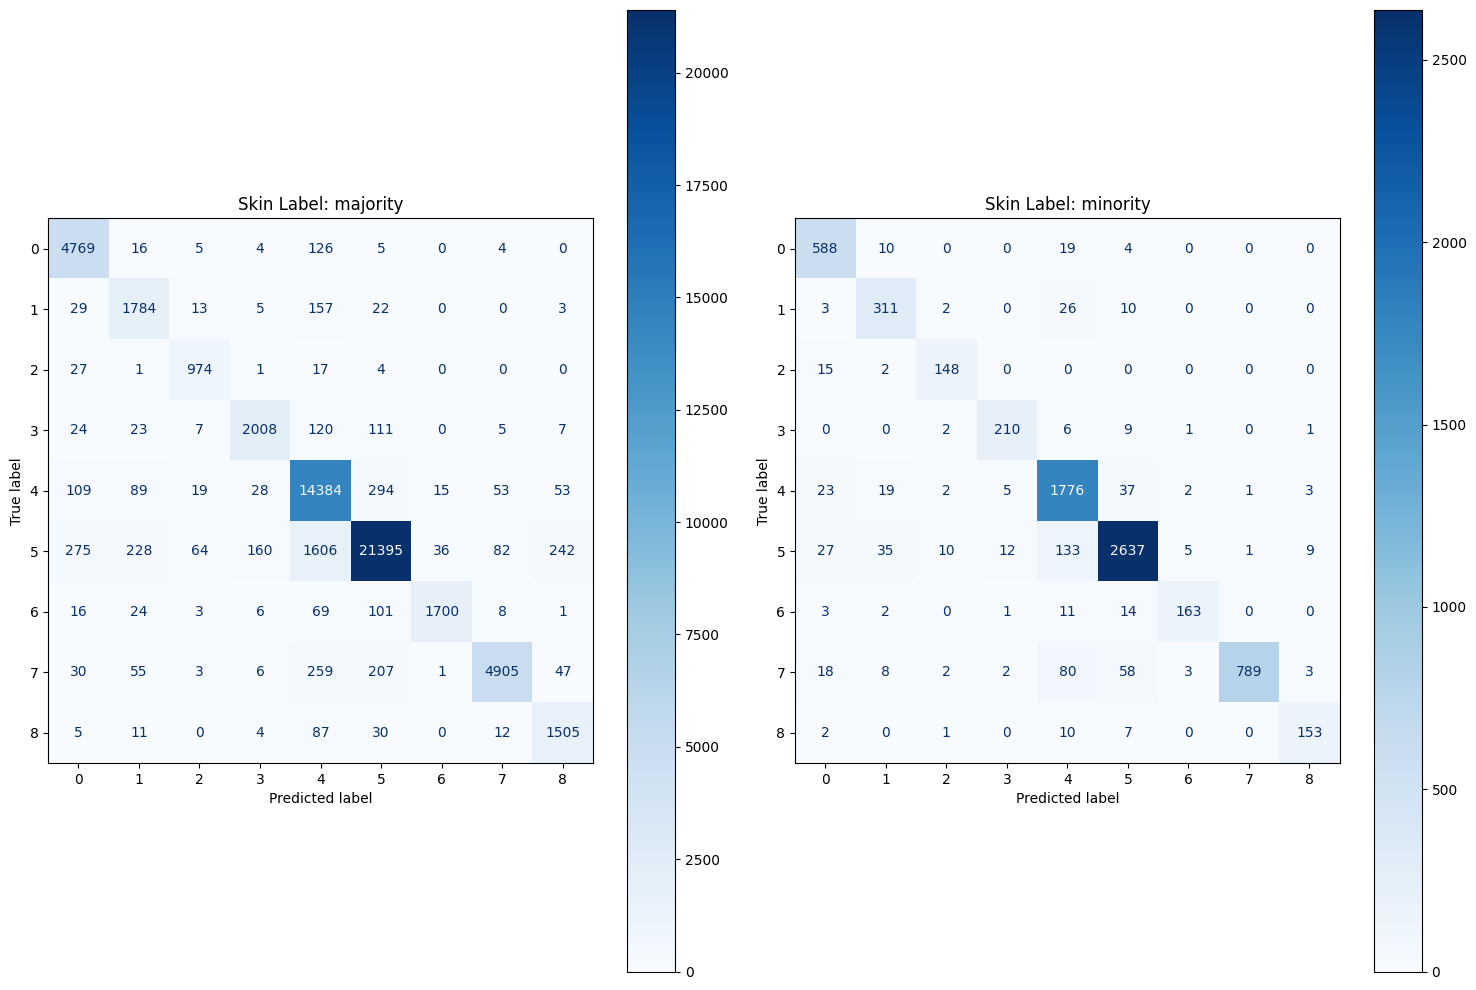

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert lists to numpy arrays for easier processing
labels_fairness = np.array(labels_fairness)
pred_fairness = np.array(pred_fairness)
groups = np.array(['minority' if skin_labels_fairness[i] == 'dark' or skin_labels_fairness[i] == 'brown' else 'majority' for i in range(len(labels_fairness))])

# Get unique skin labels
unique_skin_labels = np.unique(groups)

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes = axes.ravel()  # Flatten the axes array for easier iteration

# Plot confusion matrices for each skin label
for i, skin_label in enumerate(unique_skin_labels):
    # Filter labels and predictions for the current skin label
    indices = np.where(groups == skin_label)
    filtered_labels = labels_fairness[indices]
    filtered_predictions = pred_fairness[indices]

    # Compute confusion matrix
    cm = confusion_matrix(filtered_labels, filtered_predictions)
    
    # Create a ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    # Plot the confusion matrix on the corresponding subplot
    disp.plot(ax=axes[i], cmap=plt.cm.Blues)
    axes[i].set_title(f"Skin Label: {skin_label}")

# Adjust layout
plt.tight_layout()
plt.show()

## Disparate Impact
In the binary case, **disparate impact** is defined as
$$\frac{Pr(\hat{Y} = 1 | X \in minority\_group)}{Pr(\hat{Y} = 1 | X \in majority\_group)}$$
i.e. the ratio between the selection rate for the minority and majority group. In our case, we have a multiclass task at hand. We handle it by computing the Disparate Impact for each disease, considering $\hat{Y} = 1$ if the single disease is detected, $\hat{Y} = 0$ otherwise. Plus, we aggregate the skin tones considering the *brown* and *dark* skin tones as the **minority group** and the remaining four skin tones as the **majority group**.
The disparate impact is computed using the implementation provided by the library *holisticai*.

In [121]:
groups = ['minority' if skin_labels_fairness[i] == 'dark' or skin_labels_fairness[i] == 'brown' else 'majority' for i in range(len(labels_fairness))]

for disease_id in range(9):
  # Initialize empty lists for minority and majority groups
  pred_list = []
  labels_list = []
  minority_list = []
  majority_list = []

  # Loop through skin_labels_fairness and check the group
  for i in range(len(pred_fairness)):
      pred_list.append(1 if pred_fairness[i] == disease_id else 0)
      labels_list.append(1 if labels_fairness[i] == disease_id else 0)

      if skin_labels_fairness[i] == 'dark' or skin_labels_fairness[i] == 'brown':
          minority_list.append(1)
          majority_list.append(0)
      else:
          minority_list.append(0)
          majority_list.append(1)

  print(f'Disparate impact for disease {diseases[disease_id]}: {disparate_impact(minority_list, majority_list, pred_list):.2f}', '\n')

Disparate impact for disease esantema-iatrogeno-farmaco-indotta: 1.01 

Disparate impact for disease esantema-maculo-papuloso: 1.36 

Disparate impact for disease esantema-morbilliforme: 1.21 

Disparate impact for disease esantema-polimorfo-like: 0.81 

Disparate impact for disease esantema-virale: 0.96 

Disparate impact for disease orticaria: 0.99 

Disparate impact for disease pediculosi: 0.78 

Disparate impact for disease scabbia: 1.23 

Disparate impact for disease varicella: 0.72 



## Equalized Odds Ratio
A classifier satisfies Equalized Odds under a distribution over (X, A, Y ) (where A indicates the sensitive feature) if its prediction $\hat{Y}$ is conditionally independent of the sensitive feature A given the label Y . This is equivalent to $E(\hat{Y} |A = a, Y = y) = E(\hat{Y} |Y = y) \; ∀ \; a, y.$ Equalized odds requires that the true positive rate, $Pr(\hat{Y} = 1|Y = 1)$, and the false positive rate, $Pr(\hat{Y} = 1|Y = 0)$, are equal across groups. In our case, Equalized Odds Ratio (EOR) was computed for every disease using the implementation of the library **fairlearn**, in which EOR is defined as 'the smaller of two metrics: *true positive rate ratio* and *false positive rate ratio*. The former is the ratio between the smallest and largest of $Pr(\hat{Y} = 1|A = a, Y = 1)$, across all values of the sensitive feature(s). The latter is defined similarly, but for $Pr(\hat{Y} = 1|A = a, Y = 0)$. The equalized odds ratio of 1 means that all groups have the same true positive, true negative, false positive, and false negative rates’ [https://fairlearn.org/main/api_reference/generated/fairlearn.metrics.equalized_odds_ratio.html#fairlearn.metrics.equalized_odds_ratio]. Even in this case, the skin tones were aggregated into the same two groups used to compute the Disparate Impact Ratio.

In [134]:
groups = ['minority' if skin_labels_fairness[i] == 'dark' or skin_labels_fairness[i] == 'brown' else 'majority' for i in range(len(labels_fairness))]

for disease_id in range(len(diseases)):
  preds = [1 if pred_fairness[i] == disease_id else 0 for i in range(len(pred_fairness))]
  labels = [1 if labels_fairness[i] == disease_id else 0 for i in range(len(labels_fairness))]

  print(f'Equalized Odds Ratio for {diseases[disease_id]}: {equalized_odds_ratio(labels, preds, sensitive_features=groups):.2f}', '\n')

Equalized Odds Ratio for esantema-iatrogeno-farmaco-indotta: 0.72 

Equalized Odds Ratio for esantema-maculo-papuloso: 0.74 

Equalized Odds Ratio for esantema-morbilliforme: 0.76 

Equalized Odds Ratio for esantema-polimorfo-like: 0.73 

Equalized Odds Ratio for esantema-virale: 0.91 

Equalized Odds Ratio for orticaria: 0.74 

Equalized Odds Ratio for pediculosi: 0.61 

Equalized Odds Ratio for scabbia: 0.10 

Equalized Odds Ratio for varicella: 0.35 



## Predictive Rate Ratio
The **Predictive Rate Parity** is achieved if the **Positive Predictive Value (PPV)**, also named as **precision**, is the same across all groups. The formula for the precision is
$$
PPV = \frac{True \; Positives \; (TP)}{True \; Positives \; (TP) + False \; Positives \; (FP)}
$$
The **Predictive Rate Ratio** compares the precision between the two groups. It is calculated by taking the ratio of the PPV of one group to the PPV of another group:
$$
Predictive \; Rate \; Ratio = \frac{PPV_{minority\_group}}{PPV_{majority\_group}}
$$
In our implementation, we compute this value for each disease, with the usual division of the skin tones into the minority group and majority group. <br> <br>
We can retrieve the Predictive Rate Ratio value by considering the precision matrix relative to each disease for the minority and majority group. The function for the precision matrix is taken from the library **holisticai**. Observing the matrix, we simply compute the ratio between the precision of the minority group and of the majority group.

In [123]:
groups = ['minority' if skin_labels_fairness[i] == 'dark' or skin_labels_fairness[i] == 'brown' else 'majority' for i in range(len(labels_fairness))]
prec_matrix = precision_matrix(groups, pred_fairness, labels_fairness)
prec_matrix.head()

,0,1,2,3,4,5,6,7,8
majority,0.967539,0.886239,0.951172,0.871150,0.956129,0.888202,0.881743,0.889715,0.909915
minority,0.946860,0.883523,0.896970,0.917031,0.950749,0.919136,0.840206,0.819315,0.884393


In [135]:
for disease_id in range(len(diseases)):
  prr = prec_matrix.iloc[1,disease_id] / prec_matrix.iloc[0,disease_id]
  print(f'Predictive Rate Ratio for disease {diseases[disease_id]}: {prr:.2f}', '\n')

Predictive Rate Ratio for disease esantema-iatrogeno-farmaco-indotta: 0.98 

Predictive Rate Ratio for disease esantema-maculo-papuloso: 1.00 

Predictive Rate Ratio for disease esantema-morbilliforme: 0.94 

Predictive Rate Ratio for disease esantema-polimorfo-like: 1.05 

Predictive Rate Ratio for disease esantema-virale: 0.99 

Predictive Rate Ratio for disease orticaria: 1.03 

Predictive Rate Ratio for disease pediculosi: 0.95 

Predictive Rate Ratio for disease scabbia: 0.92 

Predictive Rate Ratio for disease varicella: 0.97 

